In [ ]:
import gc
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import timm
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from tqdm.auto import tqdm, trange
import random
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [3]:
import captum
import torch
print(f"Captum version: {captum.__version__}")
print(f"Torch version: {torch.__version__}")

Captum version: 0.8.0
Torch version: 2.7.1+cu126


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(DEVICE)
print(torch.cuda.device_count())

In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [41]:
# Data Loading
base_dir = "Dataset for Adulterated Red Chilli Powder with Brick Powder"

all_files, all_labels = [], []
label_map = {}

for class_folder in sorted(os.listdir(base_dir)):
    class_path = os.path.join(base_dir, class_folder)
    if not os.path.isdir(class_path) or class_folder == ".ipynb_checkpoints":
        continue
    label_map.setdefault(class_folder, len(label_map))
    cls_idx = label_map[class_folder]
    candidates = glob(os.path.join(class_path, "**", "*.jpg"), recursive=True)
    for img_path in candidates:
        rel_parts = os.path.relpath(img_path, class_path).split(os.sep)
        if len(rel_parts) >= 3:
            all_files.append(img_path)
            all_labels.append(cls_idx)
            
class_names = [None] * len(label_map)
for name, idx in label_map.items():
    class_names[idx] = name

print(f"Found {len(all_files)} images across {len(label_map)} classes")

Found 481 images across 12 classes


In [6]:
len(all_files)

481

In [7]:
class ChilliDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentation for training
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# Simpler transform for validation/test
test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

In [8]:
# Train-Test Split
y = np.array(all_labels)
X_train, X_test, y_train, y_test = train_test_split(
    all_files, y, test_size=0.2, stratify=y, random_state=SEED
)

train_dataset = ChilliDataset(X_train, y_train, transform=train_transform)
test_dataset = ChilliDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [9]:
uniques, counts = np.unique(all_labels, return_counts=True)
print(dict(zip(uniques.tolist(), counts.tolist())))
print(label_map)

{0: 41, 1: 40, 2: 40, 3: 40, 4: 40, 5: 40, 6: 40, 7: 40, 8: 40, 9: 40, 10: 40, 11: 40}
{'Brick powder normal sample': 0, 'Red chilli powder normal Sample': 1, 'Red chilli powder with 10_ brick powder': 2, 'Red chilli powder with 15_ brick powder': 3, 'Red chilli powder with 20_ brick powder': 4, 'Red chilli powder with 25_ brick powder': 5, 'Red chilli powder with 30_ brick powder': 6, 'Red chilli powder with 35_ brick powder': 7, 'Red chilli powder with 40_ brick powder': 8, 'Red chilli powder with 45_ brick powder': 9, 'Red chilli powder with 50_ brick powder': 10, 'Red chilli powder with 5_ brick powder': 11}


In [10]:
def get_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True)
    model.reset_classifier(num_classes)
    return model

In [11]:
class EarlyStopping:
    def __init__(self, patience: int = 5, delta: float = 0.01, path="best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)

        elif val_loss >= self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [12]:
def qpso_optimize(model_name, param_space, objective_fn, n_particles=7, max_iter=1):
    particles = [
        {key: np.random.uniform(low, high) for key, (low, high) in param_space.items()}
        for _ in range(n_particles)
    ]
    global_best = None
    best_score = -np.inf

    start_time = time.time()

    for iteration in range(max_iter):
        print(f"\n[QPSO] Iteration {iteration + 1}/{max_iter} for {model_name}")
        iteration_start = time.time()

        scores = []

        # Parallel evaluation
        with ThreadPoolExecutor() as executor:
            # tqdm progress bar
            futures = list(tqdm(
                executor.map(lambda p: (p, objective_fn(model_name, p)), particles),
                total=n_particles,
                desc=f"Evaluating particles [Iter {iteration + 1}]",
                leave=False
            ))

        for i, (particle, score) in enumerate(futures):
            print(f"[QPSO] {model_name} particle {i+1}: params={particle}, score={score:.4f}")
            if score > best_score:
                best_score = score
                global_best = particle.copy()

        iteration_time = time.time() - iteration_start
        print(f"[QPSO] Iteration {iteration + 1} completed in {iteration_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"\n[QPSO Completed] Time Taken for {model_name}: {total_time:.2f} seconds")
    return global_best

In [13]:
def train_one_fold(model, optimizer, criterion, train_loader, val_loader, epochs=20, patience=3, model_name="", fold_idx=0, show_epoch_progress=True):
    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_acc = 0
    early_stopping = EarlyStopping(patience=patience)

    epoch_iter = range(epochs)
    if show_epoch_progress:
        epoch_iter = trange(epochs, desc=f"{model_name} | Fold {fold_idx+1}", leave=False)

    for epoch in epoch_iter:
        model.train()
        correct, total = 0, 0
        running_loss = 0
        for batch in train_loader:
            x, y = batch[:2]
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        correct, total = 0, 0
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch[:2]
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        val_loss /= len(val_loader)
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        if show_epoch_progress:
            print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            break

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    return train_accs, val_accs, train_losses, val_losses, best_val_acc

In [24]:
def evaluate_on_folds(model_name, params):
    best_overall_acc = 0
    train_dataset = ChilliDataset(X_train, y_train, transform=train_transform)
    val_dataset = ChilliDataset(X_test, y_test, transform=test_transform)

    tr_loader = DataLoader(train_dataset, batch_size=int(params['batch_size']), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=int(params['batch_size']), shuffle=False)

    model = get_model(model_name, num_classes=len(label_map)).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params.get('weight_decay', 0.01))
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    _, _, _, _, val_acc = train_one_fold(model, optimizer, criterion, tr_loader, val_loader, model_name=model_name, fold_idx=-1, show_epoch_progress=False)
    return val_acc

def evaluate_best_model_kfold(model_name, best_params, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    y = np.array(all_labels)
    all_files_np = np.array(all_files)

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    y_true_all, y_pred_all = [], []
    best_accs_per_fold = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(all_files_np, y)):
        X_tr = all_files_np[train_idx]
        y_tr = y[train_idx]
        X_val = all_files_np[val_idx]
        y_val = y[val_idx]

        train_dataset = ChilliDataset(X_tr, y_tr, train_transform)
        val_dataset = ChilliDataset(X_val, y_val, test_transform)

        train_loader = DataLoader(train_dataset, batch_size=int(best_params['batch_size']), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=int(best_params['batch_size']), shuffle=False)

        model = get_model(model_name, num_classes=len(label_map)).to(DEVICE)
        optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params.get('weight_decay', 0.01))
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        ta, va, tl, vl, best_val_acc = train_one_fold(
            model, optimizer, criterion,
            train_loader, val_loader,
            model_name=model_name, fold_idx=fold, show_epoch_progress=True
        )

        train_accs.extend(ta)
        val_accs.extend(va)
        train_losses.extend(tl)
        val_losses.extend(vl)
        best_accs_per_fold.append(best_val_acc)

        if best_val_acc == max(best_accs_per_fold):
            torch.save(model.state_dict(), f"{model_name}_best_overall_fold.pth")

        model.eval()
        with torch.no_grad():
            for x, y_batch in val_loader:
                x, y_batch = x.to(DEVICE), y_batch.to(DEVICE)
                out = model(x)
                y_true_all.extend(y_batch.cpu().numpy())
                y_pred_all.extend(out.argmax(1).cpu().numpy())

    avg_val_acc = np.mean(best_accs_per_fold)
    print(f"\nAverage of Best Validation Accuracies for {model_name}: {avg_val_acc:.4f}")

    return train_accs, val_accs, train_losses, val_losses, y_true_all, y_pred_all, avg_val_acc

In [15]:
def run_qpso(model_name):
    print(f"\n>>> Optimizing {model_name}")

    best_params = qpso_optimize(
        model_name,
        param_space={'lr': (1e-5, 5e-3), 'batch_size': (8, 64), 'weight_decay': (1e-6, 1e-1)},
        objective_fn=evaluate_on_folds
    )
    print("Best Params:", best_params)
    return best_params

def run_evaluation(model_name, best_params):
    train_accs, val_accs, train_losses, val_losses, y_true, y_pred, avg_val_acc = evaluate_best_model_kfold(model_name, best_params)

    return {
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'y_true': y_true,
        'y_pred': y_pred,
        'average_accuracy': avg_val_acc,
        'report': classification_report(y_true, y_pred, output_dict=True),
        'conf_matrix': confusion_matrix(y_true, y_pred)
    }

In [16]:
def display_final_metrics(results):
    from termcolor import cprint

    print("\n====== FINAL EVALUATION METRICS ======")
    for model_name, metrics in results.items():
        print(f"\n>>> {model_name.upper()} Evaluation Report")

        print("\nClassification Report:")
        print(classification_report(metrics['y_true'], metrics['y_pred'], target_names=list(label_map.keys())))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(metrics['y_true'], metrics['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_map.keys(), yticklabels=label_map.keys())
        plt.title(f"Confusion Matrix - {model_name}", fontsize=14)
        plt.xlabel("Predicted", fontsize=12)
        plt.ylabel("True", fontsize=12)
        plt.show()
        plt.figure(figsize=(10,4))

        plt.plot(metrics['train_accs'], label='Train Accuracy', color='teal')
        plt.plot(metrics['val_accs'], label='Validation Accuracy', color='darkorange')
        plt.title(f"Accuracy vs Epochs for {model_name}", fontsize=13)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(metrics['train_losses'], label='Train Loss', color='crimson')
        plt.plot(metrics['val_losses'], label='Validation Loss', color='navy')
        plt.title(f"Loss vs Epochs for {model_name}", fontsize=13)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if 'average_accuracy' in metrics:
            print(f"\nAverage Validation Accuracy for {model_name}: {metrics['average_accuracy']:.4f}")

In [ ]:
def visualize_xai(model, image_path, true_label, predicted_label_idx, label_map, test_transform, device):
    """
    Visualizes XAI explanations (Integrated Gradients and Grad-CAM) for a given image.
    """
    model.eval()

    # Prepare image for model input
    original_image = Image.open(image_path).convert("RGB")
    input_image = test_transform(original_image).unsqueeze(0).to(device)

    # Get predicted class name
    idx_to_class = {v: k for k, v in label_map.items()}
    predicted_class_name = idx_to_class[predicted_label_idx]
    true_class_name = idx_to_class[true_label]

    print(f"\n--- XAI for Image: {os.path.basename(image_path)} ---")
    print(f"True Label: {true_class_name}, Predicted Label: {predicted_class_name}")

    # 1. Integrated Gradients
    print("Calculating Integrated Gradients...")
    ig = IntegratedGradients(model)
    # Baseline is a black image for simplicity, can be changed
    baseline = torch.zeros_like(input_image)
    attributions_ig = ig.attribute(input_image, baseline, target=predicted_label_idx, n_steps=50)
    attributions_ig_display = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

    # 2. Grad-CAM
    print("Calculating Grad-CAM...")
    # Find the last convolutional layer
    # This might need adjustment based on the specific timm model architecture.
    # For Swin Transformer, it's usually in `model.norm` or `model.layers[-1].blocks[-1].norm1`
    # Let's try to get a common last layer before the classifier.
    # A robust way is to iterate and find a Conv2d or a relevant block
    target_layer = None
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, timm.models.swin_transformer.SwinTransformerBlock)): # Adjust for Swin layers
            target_layer = module
            # You might want a specific block, for Swin, it's often the last block of the last stage
            if "layers.3.blocks.2" in name: # Example for a deeper layer in Swin
                 break
        if "head" in name: # Stop before the classification head
            break

    if target_layer is None:
        print("Warning: Could not find a suitable target layer for Grad-CAM. Skipping Grad-CAM.")
        # Fallback for common timm models, try model.head if not specific conv
        if hasattr(model, 'norm'): # Common for Vision Transformers before head
             target_layer = model.norm
        elif hasattr(model, 'blocks') and len(model.blocks) > 0: # For models with blocks
             target_layer = model.blocks[-1]
        elif hasattr(model, 'stages') and len(model.stages) > 0: # For models with stages (like Swin)
            target_layer = model.stages[-1]
            if hasattr(target_layer, 'blocks') and len(target_layer.blocks) > 0:
                target_layer = target_layer.blocks[-1]


    if target_layer:
        gc = GradCAM(model, target_layer)
        attributions_gc = gc.attribute(input_image, target=predicted_label_idx)
        attributions_gc_display = np.transpose(attributions_gc.squeeze().cpu().detach().numpy(), (1, 2, 0))
    else:
        attributions_gc_display = None


    # Visualize
    fig, ax = plt.subplots(1, 3 if attributions_gc_display is not None else 2, figsize=(18, 6))

    # Original Image
    ax[0].imshow(original_image)
    ax[0].set_title(f"Original Image\n({predicted_class_name})")
    ax[0].axis('off')

    # Integrated Gradients Visualization
    _ = viz.visualize_image_attr(
        attributions_ig_display,
        original_image.convert('RGBA'), # Convert to RGBA for proper overlay
        method="heat_map",
        cmap="inferno",
        show_colorbar=True,
        sign="absolute_value",
        outlier_perc=1,
        ax=ax[1]
    )
    ax[1].set_title("Integrated Gradients")
    ax[1].axis('off')

    # Grad-CAM Visualization
    if attributions_gc_display is not None:
        _ = viz.visualize_image_attr_common(
            attributions_gc_display,
            original_image.convert('RGBA'),
            method="blended_heat_map",
            sign="positive",
            cmap="jet",
            show_colorbar=True,
            title="Grad-CAM",
            plt_fig_axis=(fig, ax[2])
        )
        ax[2].set_title("Grad-CAM")
        ax[2].axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
results = {}

In [24]:
best_params_swin = run_qpso('swin_tiny_patch4_window7_224')


>>> Optimizing swin_tiny_patch4_window7_224

[QPSO] Iteration 1/3 for swin_tiny_patch4_window7_224


[QPSO] swin_tiny_patch4_window7_224 particle 1: params={'lr': 0.0030416488109881777, 'batch_size': 17.549350926488327, 'weight_decay': 0.006506094246934967}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 2: params={'lr': 0.004744938830894133, 'batch_size': 62.075393852175324, 'weight_decay': 0.080839926414298}, score=0.0825
[QPSO] swin_tiny_patch4_window7_224 particle 3: params={'lr': 0.00153002270817512, 'batch_size': 13.469638384357497, 'weight_decay': 0.06842361841818918}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 4: params={'lr': 0.0022063609437606106, 'batch_size': 14.834141151307614, 'weight_decay': 0.04951819583421691}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 5: params={'lr': 0.0001815987203649398, 'batch_size': 58.9219425164118, 'weight_decay': 0.025878739380020093}, score=0.8557
[QPSO] Iteration 1 completed in 3087.85 seconds

[QPSO] Iteration 2/3 for swin_tiny_patch4_window7_224


[QPSO] swin_tiny_patch4_window7_224 particle 1: params={'lr': 0.0030416488109881777, 'batch_size': 17.549350926488327, 'weight_decay': 0.006506094246934967}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 2: params={'lr': 0.004744938830894133, 'batch_size': 62.075393852175324, 'weight_decay': 0.080839926414298}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 3: params={'lr': 0.00153002270817512, 'batch_size': 13.469638384357497, 'weight_decay': 0.06842361841818918}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 4: params={'lr': 0.0022063609437606106, 'batch_size': 14.834141151307614, 'weight_decay': 0.04951819583421691}, score=0.0825
[QPSO] swin_tiny_patch4_window7_224 particle 5: params={'lr': 0.0001815987203649398, 'batch_size': 58.9219425164118, 'weight_decay': 0.025878739380020093}, score=0.9485
[QPSO] Iteration 2 completed in 3491.06 seconds

[QPSO] Iteration 3/3 for swin_tiny_patch4_window7_224


[QPSO] swin_tiny_patch4_window7_224 particle 1: params={'lr': 0.0030416488109881777, 'batch_size': 17.549350926488327, 'weight_decay': 0.006506094246934967}, score=0.0825
[QPSO] swin_tiny_patch4_window7_224 particle 2: params={'lr': 0.004744938830894133, 'batch_size': 62.075393852175324, 'weight_decay': 0.080839926414298}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 3: params={'lr': 0.00153002270817512, 'batch_size': 13.469638384357497, 'weight_decay': 0.06842361841818918}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 4: params={'lr': 0.0022063609437606106, 'batch_size': 14.834141151307614, 'weight_decay': 0.04951819583421691}, score=0.0928
[QPSO] swin_tiny_patch4_window7_224 particle 5: params={'lr': 0.0001815987203649398, 'batch_size': 58.9219425164118, 'weight_decay': 0.025878739380020093}, score=0.9175
[QPSO] Iteration 3 completed in 3826.48 seconds

[QPSO Completed] Time Taken for swin_tiny_patch4_window7_224: 10405.40 seconds
Best Params: {'lr': 0.00018

In [29]:
best_params_swin = {'lr': 0.0001815987203649398, 'batch_size': 58.9219425164118, 'weight_decay': 0.025878739380020093}

In [31]:
results['swin_tiny_patch4_window7_224'] = run_evaluation('swin_tiny_patch4_window7_224', best_params_swin)

swin_tiny_patch4_window7_224 | Fold 1:   0%|                                                      | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.1875, Val Acc = 0.4021, Train Loss = 2.2819, Val Loss = 1.5307


swin_tiny_patch4_window7_224 | Fold 1:   5%|██▎                                          | 1/20 [01:56<36:51, 116.39s/it]

Epoch 2: Train Acc = 0.5078, Val Acc = 0.6289, Train Loss = 1.2690, Val Loss = 0.8840


swin_tiny_patch4_window7_224 | Fold 1:  10%|████▌                                        | 2/20 [03:36<32:01, 106.74s/it]

Epoch 3: Train Acc = 0.6641, Val Acc = 0.7113, Train Loss = 0.8136, Val Loss = 0.7208


swin_tiny_patch4_window7_224 | Fold 1:  15%|██████▊                                      | 3/20 [05:13<29:01, 102.42s/it]

Epoch 4: Train Acc = 0.7917, Val Acc = 0.8247, Train Loss = 0.5517, Val Loss = 0.4682


swin_tiny_patch4_window7_224 | Fold 1:  20%|█████████▏                                    | 4/20 [06:49<26:34, 99.64s/it]

Epoch 5: Train Acc = 0.9219, Val Acc = 0.8351, Train Loss = 0.2647, Val Loss = 0.3400


swin_tiny_patch4_window7_224 | Fold 1:  30%|█████████████▊                                | 6/20 [10:02<22:53, 98.11s/it]

Epoch 6: Train Acc = 0.9505, Val Acc = 0.8351, Train Loss = 0.1674, Val Loss = 0.3891
Epoch 7: Train Acc = 0.9714, Val Acc = 0.8969, Train Loss = 0.1117, Val Loss = 0.3122


swin_tiny_patch4_window7_224 | Fold 1:  40%|██████████████████▍                           | 8/20 [13:16<19:29, 97.45s/it]

Epoch 8: Train Acc = 0.9818, Val Acc = 0.8351, Train Loss = 0.0702, Val Loss = 0.4532


swin_tiny_patch4_window7_224 | Fold 1:  45%|████████████████████▋                         | 9/20 [14:53<17:49, 97.24s/it]

Epoch 9: Train Acc = 0.9688, Val Acc = 0.8969, Train Loss = 0.0715, Val Loss = 0.3295
Epoch 10: Train Acc = 0.9844, Val Acc = 0.9175, Train Loss = 0.0393, Val Loss = 0.2065


swin_tiny_patch4_window7_224 | Fold 1:  55%|████████████████████████▊                    | 11/20 [18:08<14:35, 97.30s/it]

Epoch 11: Train Acc = 0.9974, Val Acc = 0.9278, Train Loss = 0.0158, Val Loss = 0.2460
Epoch 12: Train Acc = 0.9948, Val Acc = 0.9485, Train Loss = 0.0242, Val Loss = 0.1101


swin_tiny_patch4_window7_224 | Fold 1:  65%|█████████████████████████████▎               | 13/20 [21:22<11:20, 97.17s/it]

Epoch 13: Train Acc = 0.9974, Val Acc = 0.8969, Train Loss = 0.0099, Val Loss = 0.3277


swin_tiny_patch4_window7_224 | Fold 1:  70%|███████████████████████████████▍             | 14/20 [22:59<09:42, 97.11s/it]

Epoch 14: Train Acc = 0.9870, Val Acc = 0.9278, Train Loss = 0.0323, Val Loss = 0.2245


Epoch 15: Train Acc = 0.9688, Val Acc = 0.9072, Train Loss = 0.0743, Val Loss = 0.2908


swin_tiny_patch4_window7_224 | Fold 2:   0%|                                                      | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.2623, Val Acc = 0.4479, Train Loss = 2.2384, Val Loss = 1.6013


swin_tiny_patch4_window7_224 | Fold 2:   5%|██▎                                          | 1/20 [01:53<36:00, 113.70s/it]

Epoch 2: Train Acc = 0.5532, Val Acc = 0.5729, Train Loss = 1.2278, Val Loss = 0.9486


swin_tiny_patch4_window7_224 | Fold 2:  10%|████▌                                        | 2/20 [03:30<31:04, 103.60s/it]

Epoch 3: Train Acc = 0.7117, Val Acc = 0.8750, Train Loss = 0.7532, Val Loss = 0.4009


swin_tiny_patch4_window7_224 | Fold 2:  15%|██████▊                                      | 3/20 [05:08<28:36, 100.98s/it]

Epoch 4: Train Acc = 0.8545, Val Acc = 0.8750, Train Loss = 0.3873, Val Loss = 0.2815


swin_tiny_patch4_window7_224 | Fold 2:  20%|█████████▏                                    | 4/20 [06:44<26:27, 99.23s/it]

Epoch 5: Train Acc = 0.9273, Val Acc = 0.8750, Train Loss = 0.2177, Val Loss = 0.2749


swin_tiny_patch4_window7_224 | Fold 2:  25%|███████████▎                                 | 5/20 [08:27<25:05, 100.36s/it]

Epoch 6: Train Acc = 0.9403, Val Acc = 0.9167, Train Loss = 0.1527, Val Loss = 0.1933


swin_tiny_patch4_window7_224 | Fold 2:  35%|████████████████                              | 7/20 [11:41<21:20, 98.53s/it]

Epoch 7: Train Acc = 0.9714, Val Acc = 0.8750, Train Loss = 0.0869, Val Loss = 0.2748


swin_tiny_patch4_window7_224 | Fold 2:  40%|██████████████████▍                           | 8/20 [13:18<19:36, 98.04s/it]

Epoch 8: Train Acc = 0.9740, Val Acc = 0.8646, Train Loss = 0.0792, Val Loss = 0.4606
Epoch 9: Train Acc = 0.9740, Val Acc = 0.9583, Train Loss = 0.0874, Val Loss = 0.1424


swin_tiny_patch4_window7_224 | Fold 2:  45%|████████████████████▋                         | 9/20 [14:55<17:57, 97.95s/it]

Epoch 10: Train Acc = 0.9818, Val Acc = 0.9688, Train Loss = 0.0513, Val Loss = 0.1026


swin_tiny_patch4_window7_224 | Fold 2:  55%|████████████████████████▊                    | 11/20 [18:10<14:38, 97.60s/it]

Epoch 11: Train Acc = 0.9636, Val Acc = 0.8854, Train Loss = 0.0878, Val Loss = 0.2545


swin_tiny_patch4_window7_224 | Fold 2:  60%|███████████████████████████                  | 12/20 [19:46<12:58, 97.30s/it]

Epoch 12: Train Acc = 0.9403, Val Acc = 0.8958, Train Loss = 0.1096, Val Loss = 0.3181


Epoch 13: Train Acc = 0.9662, Val Acc = 0.9479, Train Loss = 0.1105, Val Loss = 0.1566


swin_tiny_patch4_window7_224 | Fold 3:   0%|                                                      | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.1662, Val Acc = 0.3958, Train Loss = 2.3342, Val Loss = 1.9007


swin_tiny_patch4_window7_224 | Fold 3:   5%|██▎                                          | 1/20 [02:13<42:15, 133.45s/it]

Epoch 2: Train Acc = 0.4805, Val Acc = 0.5312, Train Loss = 1.5310, Val Loss = 1.3360


swin_tiny_patch4_window7_224 | Fold 3:  10%|████▌                                        | 2/20 [03:59<35:12, 117.35s/it]

Epoch 3: Train Acc = 0.6883, Val Acc = 0.7500, Train Loss = 0.8251, Val Loss = 0.5576


swin_tiny_patch4_window7_224 | Fold 3:  15%|██████▊                                      | 3/20 [05:37<30:43, 108.44s/it]

Epoch 4: Train Acc = 0.8286, Val Acc = 0.7604, Train Loss = 0.4377, Val Loss = 0.3757


swin_tiny_patch4_window7_224 | Fold 3:  20%|█████████                                    | 4/20 [07:14<27:41, 103.87s/it]

Epoch 5: Train Acc = 0.9039, Val Acc = 0.8542, Train Loss = 0.2730, Val Loss = 0.3391


swin_tiny_patch4_window7_224 | Fold 3:  30%|█████████████▌                               | 6/20 [10:34<23:41, 101.57s/it]

Epoch 6: Train Acc = 0.8987, Val Acc = 0.8333, Train Loss = 0.2659, Val Loss = 0.3939


swin_tiny_patch4_window7_224 | Fold 3:  35%|████████████████                              | 7/20 [12:10<21:38, 99.86s/it]

Epoch 7: Train Acc = 0.9403, Val Acc = 0.8229, Train Loss = 0.1634, Val Loss = 0.4618
Epoch 8: Train Acc = 0.9558, Val Acc = 0.9062, Train Loss = 0.1346, Val Loss = 0.1883


swin_tiny_patch4_window7_224 | Fold 3:  40%|██████████████████▍                           | 8/20 [13:48<19:52, 99.36s/it]

Epoch 9: Train Acc = 0.9792, Val Acc = 0.9062, Train Loss = 0.0692, Val Loss = 0.1762


swin_tiny_patch4_window7_224 | Fold 3:  50%|██████████████████████▌                      | 10/20 [17:01<16:19, 97.91s/it]

Epoch 10: Train Acc = 0.9740, Val Acc = 0.8854, Train Loss = 0.1045, Val Loss = 0.2397


swin_tiny_patch4_window7_224 | Fold 3:  55%|████████████████████████▊                    | 11/20 [18:38<14:38, 97.60s/it]

Epoch 11: Train Acc = 0.9584, Val Acc = 0.9167, Train Loss = 0.1116, Val Loss = 0.3016


Epoch 12: Train Acc = 0.9792, Val Acc = 0.9167, Train Loss = 0.0655, Val Loss = 0.2650


swin_tiny_patch4_window7_224 | Fold 4:   0%|                                                      | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.2156, Val Acc = 0.3125, Train Loss = 2.3107, Val Loss = 1.7640


swin_tiny_patch4_window7_224 | Fold 4:   5%|██▎                                          | 1/20 [01:43<32:55, 104.00s/it]

Epoch 2: Train Acc = 0.4260, Val Acc = 0.5521, Train Loss = 1.5823, Val Loss = 1.3207


swin_tiny_patch4_window7_224 | Fold 4:  10%|████▌                                        | 2/20 [03:21<30:07, 100.40s/it]

Epoch 3: Train Acc = 0.6623, Val Acc = 0.6667, Train Loss = 0.9775, Val Loss = 0.8357


swin_tiny_patch4_window7_224 | Fold 4:  15%|██████▉                                       | 3/20 [04:59<28:02, 98.99s/it]

Epoch 4: Train Acc = 0.7974, Val Acc = 0.7917, Train Loss = 0.5665, Val Loss = 0.4800


swin_tiny_patch4_window7_224 | Fold 4:  25%|███████████▌                                  | 5/20 [08:12<24:25, 97.67s/it]

Epoch 5: Train Acc = 0.8416, Val Acc = 0.7812, Train Loss = 0.4223, Val Loss = 0.5680
Epoch 6: Train Acc = 0.9065, Val Acc = 0.8125, Train Loss = 0.2488, Val Loss = 0.4660


swin_tiny_patch4_window7_224 | Fold 4:  30%|█████████████▊                                | 6/20 [09:50<22:45, 97.51s/it]

Epoch 7: Train Acc = 0.9299, Val Acc = 0.8646, Train Loss = 0.2101, Val Loss = 0.4365


swin_tiny_patch4_window7_224 | Fold 4:  40%|██████████████████▍                           | 8/20 [13:02<19:21, 96.80s/it]

Epoch 8: Train Acc = 0.9558, Val Acc = 0.8229, Train Loss = 0.1171, Val Loss = 0.4713
Epoch 9: Train Acc = 0.9766, Val Acc = 0.9167, Train Loss = 0.0981, Val Loss = 0.3015


swin_tiny_patch4_window7_224 | Fold 4:  50%|██████████████████████▌                      | 10/20 [16:15<16:07, 96.76s/it]

Epoch 10: Train Acc = 0.9844, Val Acc = 0.8958, Train Loss = 0.0460, Val Loss = 0.3195


swin_tiny_patch4_window7_224 | Fold 4:  55%|████████████████████████▊                    | 11/20 [17:52<14:31, 96.81s/it]

Epoch 11: Train Acc = 0.9896, Val Acc = 0.8438, Train Loss = 0.0413, Val Loss = 0.5414
Epoch 12: Train Acc = 0.9948, Val Acc = 0.9375, Train Loss = 0.0250, Val Loss = 0.1943


swin_tiny_patch4_window7_224 | Fold 4:  65%|█████████████████████████████▎               | 13/20 [21:07<11:19, 97.09s/it]

Epoch 13: Train Acc = 0.9922, Val Acc = 0.8438, Train Loss = 0.0336, Val Loss = 0.5356
Epoch 14: Train Acc = 0.9922, Val Acc = 0.9479, Train Loss = 0.0344, Val Loss = 0.1979


swin_tiny_patch4_window7_224 | Fold 4:  75%|█████████████████████████████████▊           | 15/20 [24:25<08:09, 97.90s/it]

Epoch 15: Train Acc = 0.9532, Val Acc = 0.9271, Train Loss = 0.1542, Val Loss = 0.2865


swin_tiny_patch4_window7_224 | Fold 4:  80%|████████████████████████████████████         | 16/20 [26:03<06:32, 98.03s/it]

Epoch 16: Train Acc = 0.9065, Val Acc = 0.7396, Train Loss = 0.3270, Val Loss = 0.9642


Epoch 17: Train Acc = 0.9117, Val Acc = 0.8438, Train Loss = 0.2670, Val Loss = 0.5278


swin_tiny_patch4_window7_224 | Fold 5:   0%|                                                      | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.2312, Val Acc = 0.3958, Train Loss = 2.1923, Val Loss = 1.5558


swin_tiny_patch4_window7_224 | Fold 5:   5%|██▎                                          | 1/20 [01:47<33:56, 107.16s/it]

Epoch 2: Train Acc = 0.5455, Val Acc = 0.7292, Train Loss = 1.2208, Val Loss = 0.8419


swin_tiny_patch4_window7_224 | Fold 5:  10%|████▌                                        | 2/20 [03:26<30:40, 102.28s/it]

Epoch 3: Train Acc = 0.7662, Val Acc = 0.7188, Train Loss = 0.5898, Val Loss = 0.6450


swin_tiny_patch4_window7_224 | Fold 5:  15%|██████▊                                      | 3/20 [05:03<28:22, 100.15s/it]

Epoch 4: Train Acc = 0.8805, Val Acc = 0.8125, Train Loss = 0.3319, Val Loss = 0.4033


swin_tiny_patch4_window7_224 | Fold 5:  20%|█████████▏                                    | 4/20 [06:41<26:30, 99.40s/it]

Epoch 5: Train Acc = 0.9013, Val Acc = 0.9271, Train Loss = 0.2532, Val Loss = 0.3387


swin_tiny_patch4_window7_224 | Fold 5:  30%|█████████████▊                                | 6/20 [09:57<23:00, 98.57s/it]

Epoch 6: Train Acc = 0.9429, Val Acc = 0.8854, Train Loss = 0.1728, Val Loss = 0.3600


swin_tiny_patch4_window7_224 | Fold 5:  35%|████████████████                              | 7/20 [11:34<21:12, 97.85s/it]

Epoch 7: Train Acc = 0.9506, Val Acc = 0.9062, Train Loss = 0.1439, Val Loss = 0.4579
Epoch 8: Train Acc = 0.9766, Val Acc = 0.9688, Train Loss = 0.0870, Val Loss = 0.2663


swin_tiny_patch4_window7_224 | Fold 5:  45%|████████████████████▋                         | 9/20 [14:47<17:49, 97.26s/it]

Epoch 9: Train Acc = 0.9896, Val Acc = 0.8750, Train Loss = 0.0585, Val Loss = 0.3790


swin_tiny_patch4_window7_224 | Fold 5:  50%|██████████████████████▌                      | 10/20 [16:24<16:11, 97.16s/it]

Epoch 10: Train Acc = 0.9818, Val Acc = 0.8646, Train Loss = 0.0677, Val Loss = 0.7158
Epoch 11: Train Acc = 0.9714, Val Acc = 0.9479, Train Loss = 0.0806, Val Loss = 0.2574


swin_tiny_patch4_window7_224 | Fold 5:  60%|███████████████████████████                  | 12/20 [19:39<12:58, 97.27s/it]

Epoch 12: Train Acc = 0.9844, Val Acc = 0.9167, Train Loss = 0.0428, Val Loss = 0.5236


swin_tiny_patch4_window7_224 | Fold 5:  65%|█████████████████████████████▎               | 13/20 [21:17<11:21, 97.38s/it]

Epoch 13: Train Acc = 0.9844, Val Acc = 0.9167, Train Loss = 0.0401, Val Loss = 0.3825


Epoch 14: Train Acc = 0.9688, Val Acc = 0.9271, Train Loss = 0.0873, Val Loss = 0.3465



Average of Best Validation Accuracies for swin_tiny_patch4_window7_224: 0.9501


In [19]:
best_params_effnetb5 = run_qpso('efficientnet_b5')


>>> Optimizing efficientnet_b5

[QPSO] Iteration 1/3 for efficientnet_b5


Evaluating particles [Iter 1]:  14%|███████████▎                                                                   | 1/7 [19:52<1:59:15, 1192.52s/it]

[QPSO] efficientnet_b5 particle 1: params={'lr': 0.0018789551930483391, 'batch_size': 61.24000115895531, 'weight_decay': 0.0731996621871987}, score=0.3711


Evaluating particles [Iter 1]:  29%|██████████████████████▊                                                         | 2/7 [33:45<1:21:44, 980.96s/it]

[QPSO] efficientnet_b5 particle 2: params={'lr': 0.002997305836143213, 'batch_size': 16.737043864776446, 'weight_decay': 0.015600296039099928}, score=0.2887


Evaluating particles [Iter 1]:  43%|███████████████████████████████████▏                                              | 3/7 [42:29<51:28, 772.24s/it]

[QPSO] efficientnet_b5 particle 3: params={'lr': 0.0002998372247193154, 'batch_size': 56.50586416339637, 'weight_decay': 0.060111900059309144}, score=0.7216


Evaluating particles [Iter 1]:  57%|██████████████████████████████████████████████▊                                   | 4/7 [51:52<34:29, 689.84s/it]

[QPSO] efficientnet_b5 particle 4: params={'lr': 0.0035432821632022673, 'batch_size': 9.152731680564937, 'weight_decay': 0.09699101530634728}, score=0.1856


Evaluating particles [Iter 1]:  71%|█████████████████████████████████████████████████████████▏                      | 5/7 [1:00:30<20:55, 627.93s/it]

[QPSO] efficientnet_b5 particle 5: params={'lr': 0.004163888777594105, 'batch_size': 19.890990197983463, 'weight_decay': 0.018183314895742857}, score=0.1443


Evaluating particles [Iter 1]:  86%|████████████████████████████████████████████████████████████████████▌           | 6/7 [1:06:26<08:55, 535.28s/it]

[QPSO] efficientnet_b5 particle 6: params={'lr': 0.0009251885041686349, 'batch_size': 25.037565605734112, 'weight_decay': 0.05247611840679216}, score=0.3402


[QPSO] efficientnet_b5 particle 7: params={'lr': 0.002165405643024158, 'batch_size': 24.308831851090346, 'weight_decay': 0.06118567761934323}, score=0.2268
[QPSO] Iteration 1 completed in 4990.00 seconds

[QPSO] Iteration 2/3 for efficientnet_b5


Evaluating particles [Iter 2]:  14%|███████████▋                                                                      | 1/7 [08:27<50:46, 507.76s/it]

[QPSO] efficientnet_b5 particle 1: params={'lr': 0.0018789551930483391, 'batch_size': 61.24000115895531, 'weight_decay': 0.0731996621871987}, score=0.1031


Evaluating particles [Iter 2]:  29%|███████████████████████▍                                                          | 2/7 [20:04<51:34, 618.96s/it]

[QPSO] efficientnet_b5 particle 2: params={'lr': 0.002997305836143213, 'batch_size': 16.737043864776446, 'weight_decay': 0.015600296039099928}, score=0.1753


Evaluating particles [Iter 2]:  43%|███████████████████████████████████▏                                              | 3/7 [35:16<50:11, 752.78s/it]

[QPSO] efficientnet_b5 particle 3: params={'lr': 0.0002998372247193154, 'batch_size': 56.50586416339637, 'weight_decay': 0.060111900059309144}, score=0.8763


Evaluating particles [Iter 2]:  57%|██████████████████████████████████████████████▊                                   | 4/7 [46:44<36:21, 727.07s/it]

[QPSO] efficientnet_b5 particle 4: params={'lr': 0.0035432821632022673, 'batch_size': 9.152731680564937, 'weight_decay': 0.09699101530634728}, score=0.1959


Evaluating particles [Iter 2]:  71%|██████████████████████████████████████████████████████████▌                       | 5/7 [56:45<22:43, 681.71s/it]

[QPSO] efficientnet_b5 particle 5: params={'lr': 0.004163888777594105, 'batch_size': 19.890990197983463, 'weight_decay': 0.018183314895742857}, score=0.1856


Evaluating particles [Iter 2]:  86%|████████████████████████████████████████████████████████████████████▌           | 6/7 [1:11:55<12:39, 759.23s/it]

[QPSO] efficientnet_b5 particle 6: params={'lr': 0.0009251885041686349, 'batch_size': 25.037565605734112, 'weight_decay': 0.05247611840679216}, score=0.5773


[QPSO] efficientnet_b5 particle 7: params={'lr': 0.002165405643024158, 'batch_size': 24.308831851090346, 'weight_decay': 0.06118567761934323}, score=0.3711
[QPSO] Iteration 2 completed in 5129.58 seconds

[QPSO] Iteration 3/3 for efficientnet_b5


Evaluating particles [Iter 3]:  14%|███████████▎                                                                   | 1/7 [21:26<2:08:37, 1286.20s/it]

[QPSO] efficientnet_b5 particle 1: params={'lr': 0.0018789551930483391, 'batch_size': 61.24000115895531, 'weight_decay': 0.0731996621871987}, score=0.3814


Evaluating particles [Iter 3]:  29%|██████████████████████▊                                                         | 2/7 [30:34<1:11:00, 852.15s/it]

[QPSO] efficientnet_b5 particle 2: params={'lr': 0.002997305836143213, 'batch_size': 16.737043864776446, 'weight_decay': 0.015600296039099928}, score=0.1959


Evaluating particles [Iter 3]:  43%|███████████████████████████████████▏                                              | 3/7 [45:37<58:20, 875.22s/it]

[QPSO] efficientnet_b5 particle 3: params={'lr': 0.0002998372247193154, 'batch_size': 56.50586416339637, 'weight_decay': 0.060111900059309144}, score=0.9278


Evaluating particles [Iter 3]:  57%|█████████████████████████████████████████████▋                                  | 4/7 [1:01:59<45:52, 917.59s/it]

[QPSO] efficientnet_b5 particle 4: params={'lr': 0.0035432821632022673, 'batch_size': 9.152731680564937, 'weight_decay': 0.09699101530634728}, score=0.1959


Evaluating particles [Iter 3]:  71%|█████████████████████████████████████████████████████████▏                      | 5/7 [1:14:13<28:22, 851.23s/it]

[QPSO] efficientnet_b5 particle 5: params={'lr': 0.004163888777594105, 'batch_size': 19.890990197983463, 'weight_decay': 0.018183314895742857}, score=0.1753


Evaluating particles [Iter 3]:  86%|████████████████████████████████████████████████████████████████████▌           | 6/7 [1:19:02<11:00, 660.24s/it]

[QPSO] efficientnet_b5 particle 6: params={'lr': 0.0009251885041686349, 'batch_size': 25.037565605734112, 'weight_decay': 0.05247611840679216}, score=0.2784


[QPSO] efficientnet_b5 particle 7: params={'lr': 0.002165405643024158, 'batch_size': 24.308831851090346, 'weight_decay': 0.06118567761934323}, score=0.2990
[QPSO] Iteration 3 completed in 5767.72 seconds

[QPSO Completed] Time Taken for efficientnet_b5: 15887.31 seconds
Best Params: {'lr': 0.0002998372247193154, 'batch_size': 56.50586416339637, 'weight_decay': 0.060111900059309144}


In [22]:
results['efficientnet_b5'] = run_evaluation('efficientnet_b5', best_params_effnetb5)

efficientnet_b5 | Fold 1:   0%|                                                                                               | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.3255, Val Acc = 0.2784, Train Loss = 2.0180, Val Loss = 2.0966


efficientnet_b5 | Fold 1:  10%|████████▋                                                                              | 2/20 [02:21<21:16, 70.91s/it]

Epoch 2: Train Acc = 0.6380, Val Acc = 0.4021, Train Loss = 1.0680, Val Loss = 2.3397
Epoch 3: Train Acc = 0.7995, Val Acc = 0.5567, Train Loss = 0.6327, Val Loss = 1.6604


efficientnet_b5 | Fold 1:  15%|█████████████                                                                          | 3/20 [03:31<19:59, 70.55s/it]

Epoch 4: Train Acc = 0.8333, Val Acc = 0.6495, Train Loss = 0.4710, Val Loss = 1.0381


efficientnet_b5 | Fold 1:  20%|█████████████████▍                                                                     | 4/20 [04:38<18:25, 69.09s/it]

Epoch 5: Train Acc = 0.8255, Val Acc = 0.6804, Train Loss = 0.4604, Val Loss = 1.0199


efficientnet_b5 | Fold 1:  25%|█████████████████████▊                                                                 | 5/20 [05:48<17:25, 69.67s/it]

Epoch 6: Train Acc = 0.8906, Val Acc = 0.7423, Train Loss = 0.3520, Val Loss = 0.7502


efficientnet_b5 | Fold 1:  35%|██████████████████████████████▍                                                        | 7/20 [08:07<15:03, 69.49s/it]

Epoch 7: Train Acc = 0.9089, Val Acc = 0.7423, Train Loss = 0.2894, Val Loss = 0.9970


efficientnet_b5 | Fold 1:  40%|██████████████████████████████████▊                                                    | 8/20 [09:17<13:57, 69.77s/it]

Epoch 8: Train Acc = 0.9427, Val Acc = 0.7216, Train Loss = 0.2061, Val Loss = 1.0486
Epoch 9: Train Acc = 0.9479, Val Acc = 0.8969, Train Loss = 0.1813, Val Loss = 0.3698


efficientnet_b5 | Fold 1:  50%|███████████████████████████████████████████                                           | 10/20 [11:38<11:39, 69.92s/it]

Epoch 10: Train Acc = 0.9375, Val Acc = 0.8351, Train Loss = 0.1363, Val Loss = 0.6124


efficientnet_b5 | Fold 1:  55%|███████████████████████████████████████████████▎                                      | 11/20 [12:48<10:29, 69.99s/it]

Epoch 11: Train Acc = 0.9609, Val Acc = 0.8144, Train Loss = 0.1365, Val Loss = 0.6578


Epoch 12: Train Acc = 0.9479, Val Acc = 0.7938, Train Loss = 0.1541, Val Loss = 0.8721


efficientnet_b5 | Fold 2:   0%|                                                                                               | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.3221, Val Acc = 0.4792, Train Loss = 2.1368, Val Loss = 1.7712


efficientnet_b5 | Fold 2:  10%|████████▋                                                                              | 2/20 [02:16<20:29, 68.32s/it]

Epoch 2: Train Acc = 0.6338, Val Acc = 0.4167, Train Loss = 1.1046, Val Loss = 1.9872


efficientnet_b5 | Fold 2:  15%|█████████████                                                                          | 3/20 [03:25<19:27, 68.69s/it]

Epoch 3: Train Acc = 0.7870, Val Acc = 0.3958, Train Loss = 0.6325, Val Loss = 2.2002
Epoch 4: Train Acc = 0.7532, Val Acc = 0.7083, Train Loss = 0.6452, Val Loss = 0.8289


efficientnet_b5 | Fold 2:  25%|█████████████████████▊                                                                 | 5/20 [05:41<17:00, 68.01s/it]

Epoch 5: Train Acc = 0.8104, Val Acc = 0.6458, Train Loss = 0.5324, Val Loss = 1.0333


efficientnet_b5 | Fold 2:  30%|██████████████████████████                                                             | 6/20 [06:50<15:55, 68.22s/it]

Epoch 6: Train Acc = 0.8753, Val Acc = 0.6771, Train Loss = 0.3626, Val Loss = 0.9432
Epoch 7: Train Acc = 0.8909, Val Acc = 0.8021, Train Loss = 0.3059, Val Loss = 0.5997


efficientnet_b5 | Fold 2:  40%|██████████████████████████████████▊                                                    | 8/20 [09:07<13:41, 68.46s/it]

Epoch 8: Train Acc = 0.9169, Val Acc = 0.7604, Train Loss = 0.2328, Val Loss = 0.8672


efficientnet_b5 | Fold 2:  45%|███████████████████████████████████████▏                                               | 9/20 [10:17<12:39, 69.02s/it]

Epoch 9: Train Acc = 0.9351, Val Acc = 0.8438, Train Loss = 0.1974, Val Loss = 0.6460
Epoch 10: Train Acc = 0.9247, Val Acc = 0.8750, Train Loss = 0.2157, Val Loss = 0.4980


efficientnet_b5 | Fold 2:  50%|███████████████████████████████████████████                                           | 10/20 [11:27<11:31, 69.16s/it]

Epoch 11: Train Acc = 0.9506, Val Acc = 0.9062, Train Loss = 0.1620, Val Loss = 0.3091


efficientnet_b5 | Fold 2:  60%|███████████████████████████████████████████████████▌                                  | 12/20 [13:47<09:17, 69.66s/it]

Epoch 12: Train Acc = 0.9403, Val Acc = 0.8125, Train Loss = 0.1917, Val Loss = 0.4761


efficientnet_b5 | Fold 2:  65%|███████████████████████████████████████████████████████▉                              | 13/20 [14:56<08:06, 69.43s/it]

Epoch 13: Train Acc = 0.9455, Val Acc = 0.8229, Train Loss = 0.1833, Val Loss = 0.5464


Epoch 14: Train Acc = 0.9351, Val Acc = 0.8021, Train Loss = 0.1584, Val Loss = 0.6761


efficientnet_b5 | Fold 3:   0%|                                                                                               | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.3818, Val Acc = 0.3021, Train Loss = 1.9600, Val Loss = 2.2498


efficientnet_b5 | Fold 3:   5%|████▎                                                                                  | 1/20 [01:07<21:15, 67.12s/it]

Epoch 2: Train Acc = 0.6416, Val Acc = 0.4688, Train Loss = 1.0887, Val Loss = 1.9928


efficientnet_b5 | Fold 3:  15%|█████████████                                                                          | 3/20 [03:22<19:08, 67.53s/it]

Epoch 3: Train Acc = 0.7870, Val Acc = 0.5000, Train Loss = 0.5616, Val Loss = 2.3964
Epoch 4: Train Acc = 0.8078, Val Acc = 0.6042, Train Loss = 0.4589, Val Loss = 1.5413


efficientnet_b5 | Fold 3:  20%|█████████████████▍                                                                     | 4/20 [04:30<18:02, 67.67s/it]

Epoch 5: Train Acc = 0.8857, Val Acc = 0.6771, Train Loss = 0.3435, Val Loss = 0.9286


efficientnet_b5 | Fold 3:  30%|██████████████████████████                                                             | 6/20 [06:48<15:59, 68.55s/it]

Epoch 6: Train Acc = 0.8805, Val Acc = 0.6354, Train Loss = 0.3807, Val Loss = 1.1561
Epoch 7: Train Acc = 0.9013, Val Acc = 0.8333, Train Loss = 0.2700, Val Loss = 0.5750


efficientnet_b5 | Fold 3:  35%|██████████████████████████████▍                                                        | 7/20 [07:57<14:52, 68.66s/it]

Epoch 8: Train Acc = 0.8987, Val Acc = 0.8646, Train Loss = 0.2856, Val Loss = 0.3862


efficientnet_b5 | Fold 3:  45%|███████████████████████████████████████▏                                               | 9/20 [10:11<12:26, 67.82s/it]

Epoch 9: Train Acc = 0.9221, Val Acc = 0.8542, Train Loss = 0.2154, Val Loss = 0.4510


efficientnet_b5 | Fold 3:  50%|███████████████████████████████████████████                                           | 10/20 [11:19<11:16, 67.67s/it]

Epoch 10: Train Acc = 0.9377, Val Acc = 0.8229, Train Loss = 0.2039, Val Loss = 0.5617


Epoch 11: Train Acc = 0.9299, Val Acc = 0.6979, Train Loss = 0.2110, Val Loss = 0.8622


efficientnet_b5 | Fold 4:   0%|                                                                                               | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.3039, Val Acc = 0.2396, Train Loss = 2.1335, Val Loss = 2.0380


efficientnet_b5 | Fold 4:   5%|████▎                                                                                  | 1/20 [01:06<20:57, 66.20s/it]

Epoch 2: Train Acc = 0.6545, Val Acc = 0.5417, Train Loss = 1.1351, Val Loss = 1.2532


efficientnet_b5 | Fold 4:  10%|████████▋                                                                              | 2/20 [02:14<20:18, 67.71s/it]

Epoch 3: Train Acc = 0.7792, Val Acc = 0.6562, Train Loss = 0.6176, Val Loss = 0.8408


efficientnet_b5 | Fold 4:  15%|█████████████                                                                          | 3/20 [03:24<19:23, 68.45s/it]

Epoch 4: Train Acc = 0.8494, Val Acc = 0.7812, Train Loss = 0.4627, Val Loss = 0.5664


efficientnet_b5 | Fold 4:  20%|█████████████████▍                                                                     | 4/20 [04:33<18:18, 68.64s/it]

Epoch 5: Train Acc = 0.8208, Val Acc = 0.8125, Train Loss = 0.4574, Val Loss = 0.5249


efficientnet_b5 | Fold 4:  30%|██████████████████████████                                                             | 6/20 [06:50<16:02, 68.76s/it]

Epoch 6: Train Acc = 0.8805, Val Acc = 0.7812, Train Loss = 0.3402, Val Loss = 0.6296
Epoch 7: Train Acc = 0.9117, Val Acc = 0.8021, Train Loss = 0.2649, Val Loss = 0.4603


efficientnet_b5 | Fold 4:  35%|██████████████████████████████▍                                                        | 7/20 [07:59<14:53, 68.76s/it]

Epoch 8: Train Acc = 0.9169, Val Acc = 0.8646, Train Loss = 0.2618, Val Loss = 0.4119


efficientnet_b5 | Fold 4:  45%|███████████████████████████████████████▏                                               | 9/20 [10:16<12:35, 68.67s/it]

Epoch 9: Train Acc = 0.9065, Val Acc = 0.7708, Train Loss = 0.2550, Val Loss = 0.5434


efficientnet_b5 | Fold 4:  50%|███████████████████████████████████████████                                           | 10/20 [11:25<11:26, 68.66s/it]

Epoch 10: Train Acc = 0.9325, Val Acc = 0.8021, Train Loss = 0.2133, Val Loss = 0.5831
Epoch 11: Train Acc = 0.9221, Val Acc = 0.8438, Train Loss = 0.2114, Val Loss = 0.3876


efficientnet_b5 | Fold 4:  60%|███████████████████████████████████████████████████▌                                  | 12/20 [13:44<09:14, 69.33s/it]

Epoch 12: Train Acc = 0.9273, Val Acc = 0.8542, Train Loss = 0.2277, Val Loss = 0.5313


efficientnet_b5 | Fold 4:  65%|███████████████████████████████████████████████████████▉                              | 13/20 [14:54<08:05, 69.33s/it]

Epoch 13: Train Acc = 0.9662, Val Acc = 0.8125, Train Loss = 0.1348, Val Loss = 0.6049
Epoch 14: Train Acc = 0.9688, Val Acc = 0.9167, Train Loss = 0.0902, Val Loss = 0.2667


efficientnet_b5 | Fold 4:  75%|████████████████████████████████████████████████████████████████▌                     | 15/20 [17:11<05:45, 69.08s/it]

Epoch 15: Train Acc = 0.9714, Val Acc = 0.8542, Train Loss = 0.1261, Val Loss = 0.4322


efficientnet_b5 | Fold 4:  80%|████████████████████████████████████████████████████████████████████▊                 | 16/20 [18:21<04:36, 69.17s/it]

Epoch 16: Train Acc = 0.9610, Val Acc = 0.8125, Train Loss = 0.1303, Val Loss = 0.5798


Epoch 17: Train Acc = 0.9610, Val Acc = 0.8750, Train Loss = 0.1159, Val Loss = 0.3843


efficientnet_b5 | Fold 5:   0%|                                                                                               | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Acc = 0.3117, Val Acc = 0.3333, Train Loss = 2.0900, Val Loss = 1.8682


efficientnet_b5 | Fold 5:  10%|████████▋                                                                              | 2/20 [02:28<22:14, 74.12s/it]

Epoch 2: Train Acc = 0.6935, Val Acc = 0.4375, Train Loss = 0.9580, Val Loss = 2.0513
Epoch 3: Train Acc = 0.7610, Val Acc = 0.5104, Train Loss = 0.6842, Val Loss = 1.7587


efficientnet_b5 | Fold 5:  15%|█████████████                                                                          | 3/20 [03:41<20:52, 73.69s/it]

Epoch 4: Train Acc = 0.8130, Val Acc = 0.6667, Train Loss = 0.4628, Val Loss = 0.8638


efficientnet_b5 | Fold 5:  20%|█████████████████▍                                                                     | 4/20 [04:55<19:42, 73.93s/it]

Epoch 5: Train Acc = 0.8597, Val Acc = 0.8646, Train Loss = 0.3953, Val Loss = 0.4629


efficientnet_b5 | Fold 5:  30%|██████████████████████████                                                             | 6/20 [07:23<17:15, 73.95s/it]

Epoch 6: Train Acc = 0.8961, Val Acc = 0.7917, Train Loss = 0.2952, Val Loss = 0.7416


efficientnet_b5 | Fold 5:  35%|██████████████████████████████▍                                                        | 7/20 [08:38<16:03, 74.11s/it]

Epoch 7: Train Acc = 0.9039, Val Acc = 0.8438, Train Loss = 0.2306, Val Loss = 0.6159


Epoch 8: Train Acc = 0.9195, Val Acc = 0.7396, Train Loss = 0.2488, Val Loss = 1.0082



Average of Best Validation Accuracies for efficientnet_b5: 0.8898


In [67]:
class SwinCAM:
    def __init__(self, model, target_layer='norm'):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_full_backward_hook(backward_hook)
                break

    def generate_cam(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.unsqueeze(0).to(next(self.model.parameters()).device)
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        gradients = self.gradients[0]
        activations = self.activations[0]

        weights = gradients.mean(dim=(1, 2))
        
        
        device = activations.device
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]


        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        return cam

    def overlay_cam_on_image(self, cam, img_tensor):
        # Unnormalize image (ImageNet mean and std)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
        img_tensor = img_tensor * std + mean

        # Convert to NumPy
        img = img_tensor.permute(1, 2, 0).detach().cpu().numpy()
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)

        # Apply heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay
        overlayed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
        overlayed_img = np.clip(overlayed_img / 255.0, 0, 1)

        return overlayed_img

In [68]:
def evaluate_and_explain(model, dataloader, class_names, model_name, n_images=5):
    xai = SwinCAM(model)
    model.eval()

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
    ])

    shown = 0
    for images, labels in dataloader:
        for i in range(len(images)):
            input_tensor = images[i]
            label = labels[i].item()
            cam = xai.generate_cam(input_tensor)
            overlay = xai.overlay_cam_on_image(cam, input_tensor)

            plt.figure(figsize=(6, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(input_tensor.permute(1, 2, 0))
            plt.title(f"True: {class_names[label]}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(overlay)
            plt.title("CAM Overlay")
            plt.axis('off')

            plt.tight_layout()
            plt.savefig(f"xai_output/{model_name}_explain_{shown}.png")
            plt.close()
            shown += 1
            if shown >= n_images:
                return

In [69]:
def unnormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

In [70]:
def evaluate_on_test_set(model_name, best_params, X_test_final, y_test_final):
    print(f"\n>>> Evaluating {model_name} on Test Set")

    test_dataset = ChilliDataset(X_test_final, y_test_final, test_transform)
    test_loader = DataLoader(test_dataset, batch_size=int(best_params['batch_size']), shuffle=False)

    model = get_model(model_name, num_classes=len(label_map)).to(DEVICE)
    model.load_state_dict(torch.load(f"{model_name}_best_overall_fold.pth"))
    model.eval()

    y_true, y_pred = [], []
    correct, total, running_loss = 0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)

            running_loss += loss.item()
            correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)

            y_true.extend(yb.cpu().numpy())
            y_pred.extend(out.argmax(1).cpu().numpy())

    test_acc = correct / total
    test_loss = running_loss / len(test_loader)
    
    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
    
    print("\n>>> Generating Explainable AI Visualizations on Test Set")
    evaluate_and_explain(model, test_loader, class_names=class_names, model_name=model_name)

    return test_acc, test_loss, y_true, y_pred

In [71]:
def plot_metrics(train_accs, val_accs, train_losses, val_losses,
                 test_acc, test_loss, y_true, y_pred, class_names, model_name="Model"):

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Accuracy vs Epochs
    axs[0].plot(train_accs, label="Train Acc", color="blue")
    axs[0].plot(val_accs, label="Val Acc", color="orange")
    axs[0].hlines(test_acc, 0, len(train_accs), colors="green", label="Test Acc", linestyles="dashed")
    axs[0].set_title("Accuracy vs Epochs")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].grid(True)

    # Loss vs Epochs
    axs[1].plot(train_losses, label="Train Loss", color="blue")
    axs[1].plot(val_losses, label="Val Loss", color="orange")
    axs[1].hlines(test_loss, 0, len(train_losses), colors="green", label="Test Loss", linestyles="dashed")
    axs[1].set_title("Loss vs Epochs")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Training Metrics - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [72]:
test_acc, test_loss, y_true, y_pred = evaluate_on_test_set(
    model_name='swin_tiny_patch4_window7_224',
    best_params=best_params_swin,
    X_test_final=X_test,
    y_test_final=y_test
)


>>> Evaluating swin_tiny_patch4_window7_224 on Test Set
Test Accuracy: 0.9691, Test Loss: 0.0798

>>> Generating Explainable AI Visualizations on Test Set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].


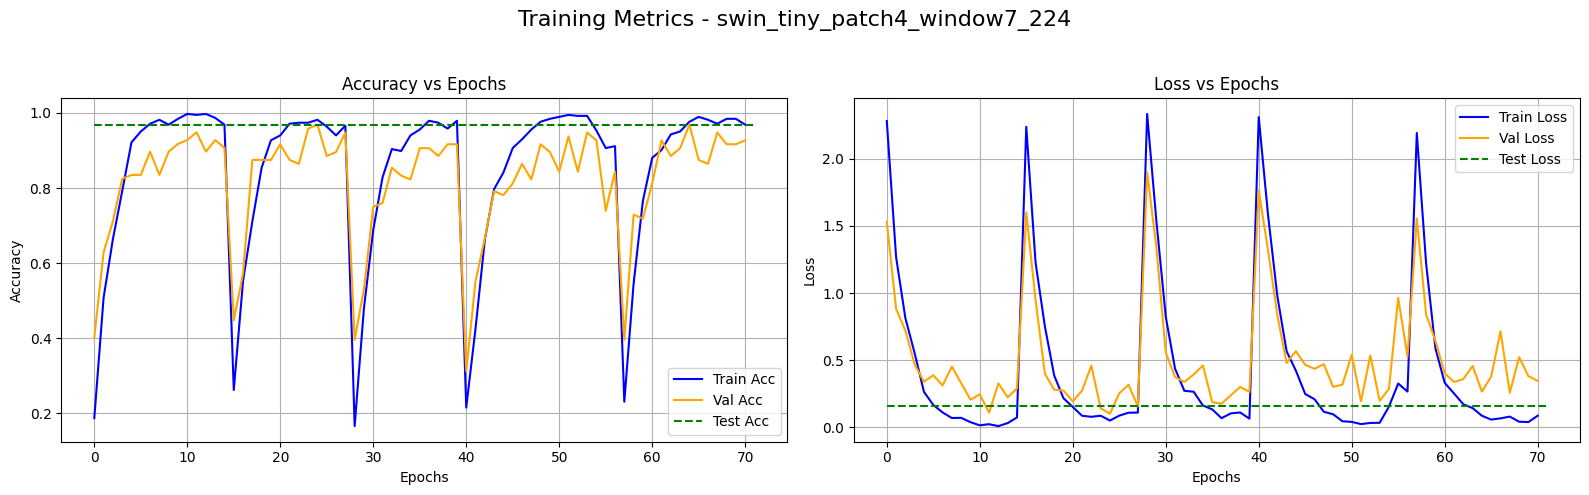


Confusion Matrix:


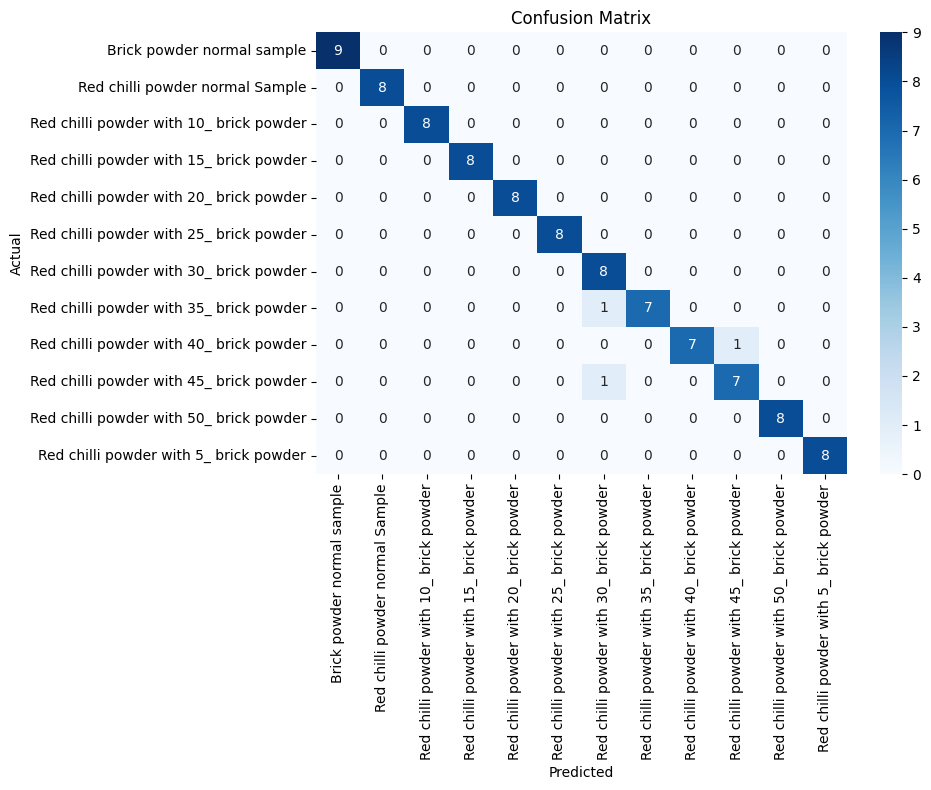


Classification Report:
                                         precision    recall  f1-score   support

             Brick powder normal sample       1.00      1.00      1.00         9
        Red chilli powder normal Sample       1.00      1.00      1.00         8
Red chilli powder with 10_ brick powder       1.00      1.00      1.00         8
Red chilli powder with 15_ brick powder       1.00      1.00      1.00         8
Red chilli powder with 20_ brick powder       1.00      1.00      1.00         8
Red chilli powder with 25_ brick powder       1.00      1.00      1.00         8
Red chilli powder with 30_ brick powder       0.80      1.00      0.89         8
Red chilli powder with 35_ brick powder       1.00      0.88      0.93         8
Red chilli powder with 40_ brick powder       1.00      0.88      0.93         8
Red chilli powder with 45_ brick powder       0.88      0.88      0.88         8
Red chilli powder with 50_ brick powder       1.00      1.00      1.00         8
 Re

In [59]:
plot_metrics(
    train_accs=results["swin_tiny_patch4_window7_224"]["train_accs"],
    val_accs=results["swin_tiny_patch4_window7_224"]["val_accs"],
    train_losses=results["swin_tiny_patch4_window7_224"]["train_losses"],
    val_losses=results["swin_tiny_patch4_window7_224"]["val_losses"],
    test_acc=test_acc,
    test_loss=test_loss,
    y_true=y_true,
    y_pred=y_pred,
    class_names=list(label_map.keys()),
    model_name="swin_tiny_patch4_window7_224"
)

In [ ]:
# Existing code after run_evaluation and results are populated
# For example, in a new cell after the QPSO and evaluation runs,
# or within the display_final_metrics function (though a separate call is cleaner).

# Assuming 'results' dictionary holds the evaluation results
# and `model_name` (e.g., 'swin_tiny_patch4_window7_224') is known.

# Load the best model (replace with your actual best model loading logic)
# This assumes you saved the best model state dict from evaluate_best_model_kfold
model_to_explain = get_model(model_name='swin_tiny_patch4_window7_224', num_classes=len(label_map)).to(DEVICE)
model_path = f"{'swin_tiny_patch4_window7_224'}_best_overall_fold.pth" # Adjust if your saving path is different
if os.path.exists(model_path):
    model_to_explain.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model_to_explain.eval()
    print(f"\nLoaded best model from {model_path} for XAI.")
else:
    print(f"\nWarning: Model '{model_path}' not found. Cannot perform XAI. Please ensure the model is saved correctly.")
    # You might want to retrain or load another model here if the file is missing.

# Select a few images from the test set for XAI
# You can modify this to select specific images of interest.
num_xai_samples = 3
xai_indices = random.sample(range(len(X_test)), min(num_xai_samples, len(X_test)))

print("\n--- Generating XAI Visualizations for Sample Images ---")
for i, idx in enumerate(xai_indices):
    image_path = X_test[idx]
    true_label = y_test[idx]

    # Get model prediction for the current image
    original_image_for_pred = Image.open(image_path).convert("RGB")
    input_image_for_pred = test_transform(original_image_for_pred).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model_to_explain(input_image_for_pred)
        predicted_label_idx = output.argmax(1).item()

    visualize_xai(model_to_explain, image_path, true_label, predicted_label_idx, label_map, test_transform, DEVICE)

# Continue with your existing display_final_metrics call if desired
# display_final_metrics(results)

100%|██████████| 1000/1000 [00:01<00:00, 507.86it/s]


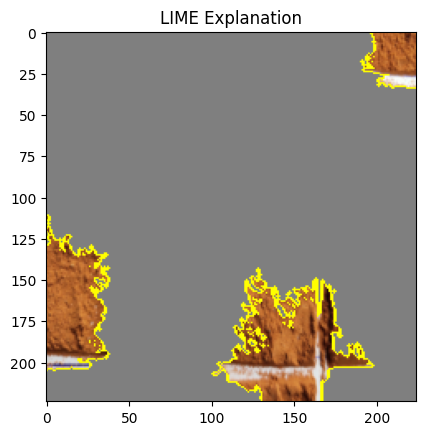

In [74]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

model_name = "swin_tiny_patch4_window7_224"
model = get_model(model_name, num_classes=len(label_map)).to(DEVICE)
model.eval()

def predict_fn(images):
    images = torch.from_numpy(images).permute(0, 3, 1, 2).float().to(DEVICE)
    with torch.no_grad():
        logits = model(images)
    return torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

image, label = test_dataset[10] # Using 11th image as an example

# Get an explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image.permute(1, 2, 0).cpu().numpy(),
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.show()

In [ ]:
import shap
import numpy as np # Make sure numpy is imported

# Ensure the model is in evaluation mode
model.eval()

# We need a batch of images to act as the background distribution
images, _ = next(iter(test_loader))
images = images.to(DEVICE)

# Use a subset of the data as a background for the explainer
background = images[:100]

# --- FIX: Use GradientExplainer and a safe slice of images ---
explainer = shap.GradientExplainer(model, background)

# Explain the first 5 images in the batch
images_to_explain = images[:5]
shap_values = explainer.shap_values(images_to_explain)


# --- FIX 2: Transpose SHAP values from (N, C, H, W) to (N, H, W, C) for plotting ---
# The output of shap_values is a list of arrays, one for each class.
# We need to transpose each of these arrays.
shap_values_transposed = [np.transpose(s, (0, 2, 3, 1)) for s in shap_values]


# --- FIX 3: Un-normalize the images for correct visualization ---
# Clone the images to avoid changing the original tensor
unnormalized_images = images_to_explain.clone()

# Define the means and stds used for normalization
mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)

# Un-normalize by multiplying by std and adding the mean
unnormalized_images = unnormalized_images * std + mean

# Convert to numpy and transpose for plotting
pixel_values_to_plot = unnormalized_images.cpu().permute(0, 2, 3, 1).numpy()


# Now plot the explanations with the corrected data
shap.image_plot(
    shap_values_transposed,
    pixel_values_to_plot,
    show=False
)
plt.suptitle("SHAP Explanations (GradientExplainer)")
plt.show()